In [9]:
import sys
import numpy as np
import os
import pickle
import math
import warnings
import optuna
import shutil
import urllib.request as request
import requests
from contextlib import closing
import datetime
from dateutil.relativedelta import relativedelta
import calendar
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
import numpy.ma as ma
from scipy.stats import pearsonr

from simulai.io import MapValid
from simulai.rom import IPOD
from simulai.simulation import Pipeline
from simulai.metrics import L2Norm
from simulai.math.differentiation import CollocationDerivative
from simulai.regression import OpInf

### Downloading Sea Surface Temperature (SST) dataset

In [2]:
def getSST(var="ssta", path:str=None, start_year:int=1854, end_year:int=2021) -> tuple:
    l = [(year, month) for year in range(start_year, end_year) for month in range(1, 13)] + [(end_year, 1)]
    DIR = path
    if not os.path.isdir(DIR):
        os.mkdir(DIR)
    else:
        pass
    for year, month in l:
        fname = f"ersst.v5.{year}{month:02d}.nc"
        if not os.path.isfile(os.path.join(DIR, fname)):
            sys.stdout.write("\r Downloading {}".format(fname))
            url = "https://www1.ncdc.noaa.gov/pub/data/cmb/ersst/v5/netcdf/"
            req = requests.get(url + fname)
            with open(DIR + "/" + fname, "wb") as f:
                f.write(req.content)
        else:
            sys.stdout.write("\r File already downloaded.")
        sys.stdout.flush()
        
    t = []
    sst = []
    for year, month in l:
        t.append(datetime.datetime(year, month, 1))
        fname = f"ersst.v5.{year}{month:02d}.nc"
        if not os.path.isfile(os.path.join(DIR, fname)):
            ds = Dataset(DIR + "/" + fname)
        else:
            ds = Dataset(os.path.join(DIR, fname))
        sst.append(np.squeeze(ds.variables[var][:].data))
    lat = ds.variables["lat"][:].data
    lon = ds.variables["lon"][:].data
    sst = np.stack(sst)
    mask = np.squeeze(ds.variables[var][:].mask)

    return sst, t, lat, lon, mask

In [3]:
data_path = '/tmp'
sst_dataset, t, lat, lon, mask = getSST("ssta", path=data_path, end_year=1912)

 File already downloaded.

### Creating train and test datasets

In [4]:
dataset_name = 'sst'
n_samples = sst_dataset.shape[0]

validation_samples = 24 # 24 months
test_samples = 24  # 24 months
train_samples = n_samples - validation_samples - test_samples

# Sub-dividing the original dataset into train, validation and test
train_sst_dataset = sst_dataset[:train_samples, ...]

validation_sst_dataset = sst_dataset[train_samples:train_samples + validation_samples, ...]

test_sst_dataset = sst_dataset[train_samples + validation_samples:, ...]

### Some basic parameters

In [5]:
data_preparer_config = {}
invalid_value = -999.
n_components = 120

### Executing dimensionality reduction

In [6]:
# We are using POD/IPOD ROMs
rom_config = {
    'n_components': n_components, #  number of POD (PCA) components
    'mean_component': True #  It is necessary to remove the mean (True or False)
}

# Pipeline instantiation for executing data preparation and dimensionality reduction
pipeline = Pipeline(stages=[('data_preparer', MapValid(config=data_preparer_config,
                                                       mask=invalid_value)),
                            ('rom', IPOD(config=rom_config))],
                    channels_last=True)

# properly executing the pipeline
pipeline.exec(input_data=train_sst_dataset,
              data_interval=[0, train_samples],  # The pipeline is executed for the testing data
              batch_size=train_samples)

Executing a global pipeline.
Executed operation MAP_VALID.
Relative Modal Energy 0.9697396755218506
Executed operation IPOD.


### Evaluating projection error

In [7]:
# Testing to project and reconstruct the data
# The projected data usually can be allocated in memory
projected_test = pipeline.project_data(data=test_sst_dataset,
                                       data_interval=[train_samples + validation_samples,
                                                      train_samples + validation_samples + test_samples],
                                       batch_size=test_samples)

# Tesating to reconstruct the just projected data
reconstructed_test = pipeline.reconstruct_data(data=projected_test)

# Evaluating error
l2_norm = L2Norm()
error = l2_norm(data=reconstructed_test[:], reference_data=test_sst_dataset,
                relative_norm=True
                )
print(f"The projection error is {100*error} %")

Applying the global reconstruction strategy.
The projection error is 0.033132687156595106 %


### Plotting reconstruction maps

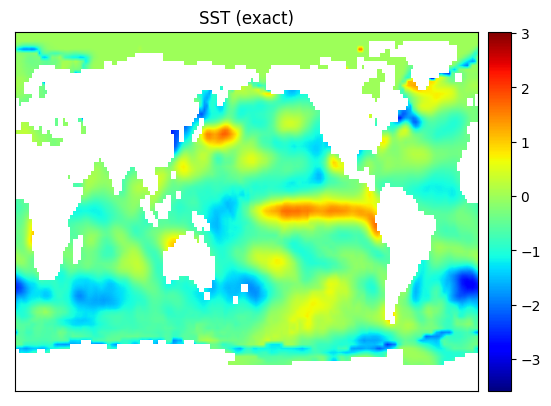

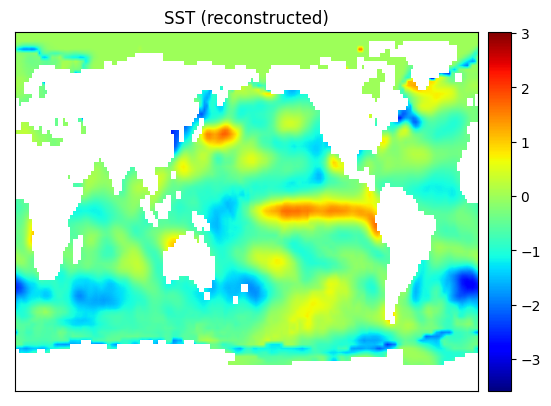

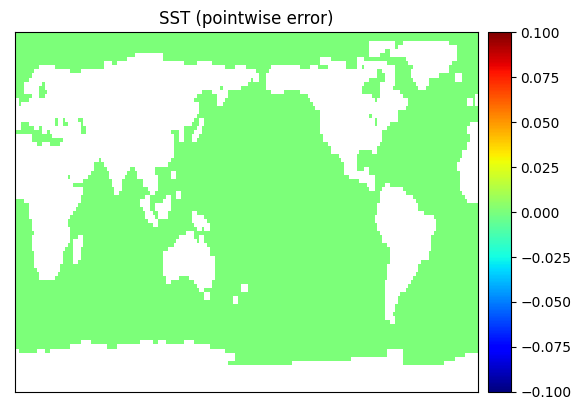

In [8]:
nlats = sst_dataset.shape[1]
nlons = sst_dataset.shape[2]

field_ = sst_dataset[-1]
field = np.where(field_ == invalid_value, np.NaN, field_)

field_rec_ = reconstructed_test[-1]
field_rec = np.where(field_ == invalid_value, np.NaN, field_)

error = field_rec - field

# Exact
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

cmap = plt.cm.get_cmap('jet').copy()
cmap.set_bad('black', np.NaN)

m.imshow(field, cmap=cmap, interpolation='bilinear')
m.colorbar()

plt.title("SST (exact)")
plt.show()

# Reconstructed
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

cmap = plt.cm.get_cmap('jet').copy()
cmap.set_bad('black', np.NaN)

m.imshow(field_rec, cmap=cmap, interpolation='bilinear')
m.colorbar()

plt.title("SST (reconstructed)")
plt.show()

# Error 
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

cmap = plt.cm.get_cmap('jet').copy()
cmap.set_bad('black', np.NaN)

m.imshow(field_rec - field, cmap=cmap, interpolation='bilinear')
m.colorbar()

plt.title("SST (pointwise error)")
plt.show()